
**Remark: please answer each question in its own cell.**

On Quercus, submit both a PDF printout of your assignment (for easier grading) and the ipynb file.

# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [6]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

     |████████████████████████████████| 57 kB 5.6 MB/s 


In [4]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 210MB/s]


In [5]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [2]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: 
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)  
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? \\

Fit_on_texts follows a loop for all the words in the “messages’ variable and simultaneously changes the “frequency tracking dictionary” for all words. It does so by increasing the count by 1 if the word is already present or initializing it to 1 if it encounters a new word. 

**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

Texts_to_sequences inputs a list of words and returns a list of the indices for the given words. These indices are such that the smaller indices have higher frequency derived from the “frequency tracking dictionary”

**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

"Pad sequences" accepts a list of sequences and adds padding to the beginning of each sequence in the returned list, ensuring that all sequences in the given list are the same length. Unless a length restriction is supplied into the function, this will be the length of the longest sequence. The padding value is set to 0 by default, and the 0th index in the frequency dictionary is reserved for padding, though this value can be changed.

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [7]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

In [11]:
biggest = 0
smallest = 1000

for i in messages_train:
  biggest = max(biggest, max(i))

for i in messages_train:
  smallest = min(smallest, min(i))


print(biggest)
print(smallest)

1999
0


In [42]:
messages_train

array([[ 634,   12,  239, ...,  156,  206,  352],
       [  10,   37,   97, ...,   89,  103,    9],
       [   0,    0,    0, ...,    2,  712,   64],
       ...,
       [   0,    0,    0, ..., 1611,    2,  601],
       [   0,    0,    0, ...,  244,  103,  125],
       [   0,    0,    0, ...,  481,   70,   72]], dtype=int32)

**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

We have a 2D array with each element being an integer sequence. Due to our set variables, these integers do not exceed 1999, which is the expected bound of the series. We can observe that the shorter sequences have been padded with 0s at the start. As a result, the obtained array for "messages train" has the anticipated format.

# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows. 

In [43]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

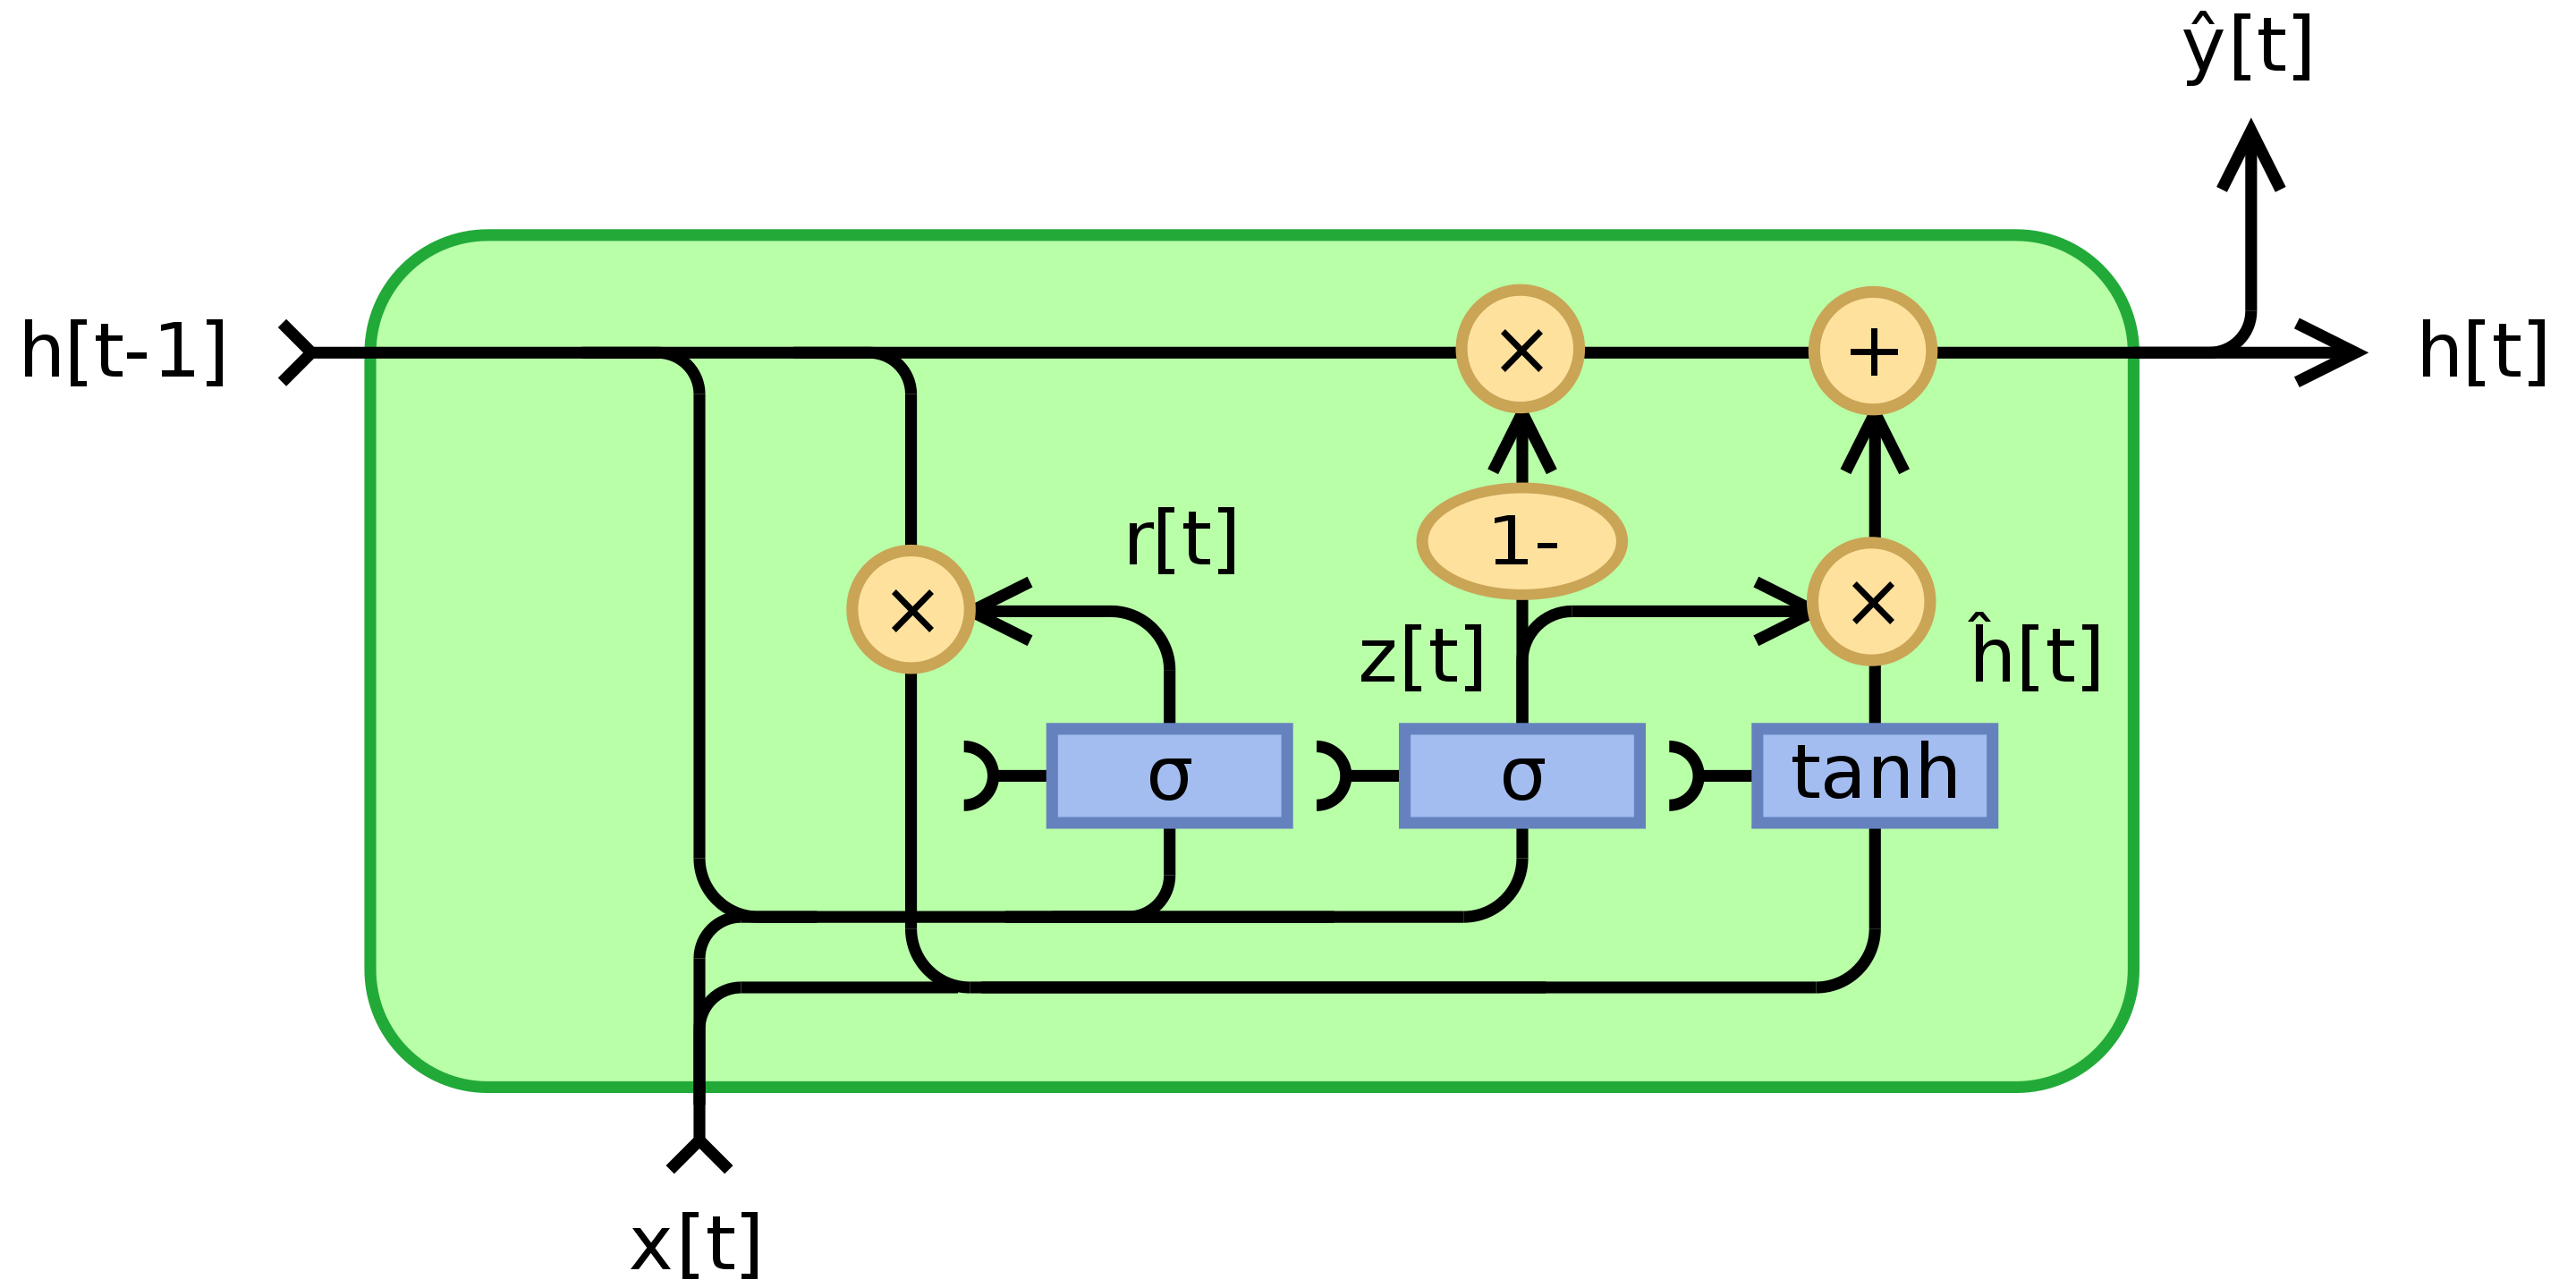

To learn more about GRU, please watch these short videos:

https://www.coursera.org/lecture/intro-to-deep-learning/modern-rnns-lstm-and-gru-WpduX

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6[3 points]:** In the following implementation, complete the `__call__` function. 

In [13]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        # z-update
        # r-
        # h-output
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            # fill this in z_t
            update_gate = objax.functional.sigmoid(jn.dot(x,self.update_w.value)+jn.dot(state, self.update_u.value)+self.update_b.value)

            # fill this in r_t
            reset_gate = objax.functional.sigmoid(jn.dot(x, self.reset_w.value)+jn.dot(state, self.reset_u.value)+self.reset_b.value)
            
            # fill this in ĥ_t
            output_gate =  objax.functional.tanh(jn.dot(x, self.output_w.value) + jn.dot(jn.multiply(reset_gate, state), self.output_u.value) + self.output_b.value)
            
            #return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.
            # return jn.multiply((1-update_gate), state) + jn.multiply((update_gate), output_gate), 0 
        
        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**Questions 7** (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?

In [16]:
def cumulative_sum(digits):
  # Calculate Cumulative Sum of nums in array
  return_array = []
  total = 0
  for digit in digits:
    total += digit #increase total by each number
    return_array.append(total)
  return jn.array(return_array)



# Using lax.scan:
def cumulative_sum_lax(total, digits):
  total_final = total + digits
  return total_final, total_final

#Input testing
x = jn.array([6, 9, 69, 699])

print('Regular Cumulative Sum:')
print(cumulative_sum(x))

output, results = lax.scan(cumulative_sum_lax, 0, x)
print('Lax Cumulative Sum:')
print(results)

Regular Cumulative Sum:
[  6  15  84 783]
Lax Cumulative Sum:
[  6  15  84 783]


In [17]:
_ = GRU(3,3)
_.update_w

objax.TrainVar(DeviceArray([[-0.97602016,  0.1467544 , -0.15334696],
             [ 0.27922988, -0.23576783,  0.17683385],
             [-0.06900861,  0.35525587,  0.2123897 ]], dtype=float32), reduce=reduce_mean)

# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. In fact input is the one-hot encoding of each review.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [19]:
# fill this in:
gru_rnn = objax.nn.Sequential([
    Embed(max_vocab, embedding_size),
    GRU(embedding_size, num_hidden_units_GRU),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),    
    objax.nn.Linear(num_hidden_units, 2)

])

# x = jn.arange(0, max_len) # Jax Array which should be of length max_len
# _ = gru_rnn(x)
# _

In [20]:
x = messages_train[0:1]
print(x)

y = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
print(y)


[[ 634   12  239  110  846   36  172   30  224  196    1  434  365   55
     3  279    7    7  157 1726  190    6    1  738 1993    1 1180    4
  1882    2  146  145    3  226    4    3  207  326    2  145 1077   16
    88    4  132   18   10  154   99    4    1  300   11   17  989   36
     1  495  492  250   73   76  106  106  696   60   85 1057 1343    5
   229  132   23   31  138  212 1133   14   31    3    2    8   11    6
     3  448   14  619    4    1  719    1 1245    2   73    1  164 1514
     1 1239    5 1674    1  888 1261    5    1  309  140    2  410  624
     7    7    1  272    6 1010    5   26   39   14 1378  217   65    2
    46    6   30  224   27  191 1473    8 1088   18   10   84    1  227
    66  358   68   54   27    5   15   44   21  193    5    3  879 1773
    22   25    5  160  197  176    3  111   12 1569  472   75  221    5
   327    2   35   23   51   71 1890   14    9 1388   11   19    6    3
    16   61    1  469  533    2    3  171 1776    5  586    9   

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [21]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w         60000 (2000, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[3](Linear).b           60 (60,)
(Sequential)[3](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       67472


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU. 

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [22]:
## Your implementaiton of the optimizer should go here
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [23]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))), gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [24]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [25]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [26]:
# you code for the training loop should start here 
def train(EPOCHS = 20, BATCH = 20, LEARNING_RATE = 9e-4):
  

  # Creating 4 lists to store values
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  # Training Loop
  for epoch in range(EPOCHS):
      avg_train_loss = 0             # average training loss per batch
      avg_val_loss =  0              # average validation loss per batch
      train_accuracy = 0             # training accuracy per batch
      validation_accuracy = 0        # validation accuracy per batch

      # removing corelation
      train_indices = np.arange(len(messages_train)) 
      np.random.shuffle(train_indices)

      for it in range(0, messages_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch) #changing avg_train_loss
          train_prediction = predict(messages_train[batch]).argmax(1) 
          train_accuracy += (np.array(train_prediction).flatten() == labels_train[batch]).sum() #changing train_accuracy

      train_accuracy.append(train_accuracy/messages_train.shape[0]) #getting final value
      avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0]) # getting final avg_train_loss_epoch

      # Validation set
      val_indices = np.arange(len(messages_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, messages_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
          val_prediction = predict(messages_valid[batch]).argmax(1)
          validation_accuracy += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()

      validation_accuracy.append(val_acc/messages_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % 
            (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_accuracy/messages_train.shape[0], 100*validation_accuracy/messages_valid.shape[0]))
  
  # Print Test Accuracy
  print(f"Test Accuracy: {round(float(accuracy(test_data))*100,2)}%")

  # Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")

  # Adding labels
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()
  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 138.33 Validation Loss 137.72 Training Accuracy 54.20 Validation Accuracy 56.14
Epoch 0002  Training Loss 136.38 Validation Loss 133.62 Training Accuracy 58.80 Validation Accuracy 59.90
Epoch 0003  Training Loss 131.71 Validation Loss 125.41 Training Accuracy 62.37 Validation Accuracy 64.34
Epoch 0004  Training Loss 125.37 Validation Loss 151.06 Training Accuracy 65.94 Validation Accuracy 55.22
Epoch 0005  Training Loss 119.99 Validation Loss 110.79 Training Accuracy 69.00 Validation Accuracy 71.32
Epoch 0006  Training Loss 115.26 Validation Loss 164.64 Training Accuracy 70.86 Validation Accuracy 59.12
Epoch 0007  Training Loss 112.69 Validation Loss 107.97 Training Accuracy 72.53 Validation Accuracy 72.04
Epoch 0008  Training Loss 109.13 Validation Loss 99.04 Training Accuracy 73.42 Validation Accuracy 76.96
Epoch 0009  Training Loss 106.50 Validation Loss 95.48 Training Accuracy 75.06 Validation Accuracy 78.38
Epoch 0010  Training Loss 104.70 Validation Loss

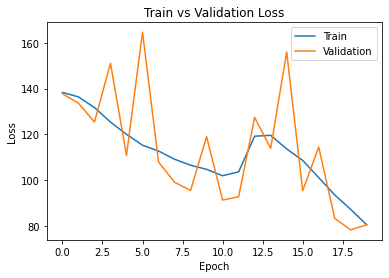

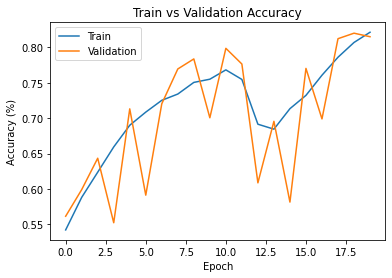

In [27]:
train(BATCH=200)

In [28]:
print(f"Test Accuracy: {round(float(accuracy(test_data))*100,2)}%")

Test Accuracy: 81.16%


**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [29]:
# Define (again) your model here
gru_rnn_adam = objax.nn.Sequential([
    Embed(max_vocab, embedding_size),
    GRU(embedding_size, num_hidden_units_GRU),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),    
    objax.nn.Linear(num_hidden_units, 2)
])


In [30]:
## Your implementaiton of the optimizer should go here
opt_adam = objax.optimizer.Adam(gru_rnn_adam.vars())

You will also need the following functions.

In [31]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn_adam(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv_adam = objax.GradValues(loss_function, gru_rnn_adam.vars())


@objax.Function.with_vars(gv_adam.vars() + opt_adam.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv_adam(x, y)
    opt_adam(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn_adam(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn_adam.vars())
predict = eval_op

In [32]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)


In [33]:
# you code for the training loop should start here 
def train(EPOCHS = 20, BATCH = 20, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(messages_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, messages_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(messages_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
      train_acc_epoch.append(train_acc/messages_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

      # run validation
      val_indices = np.arange(len(messages_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, messages_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
          val_prediction = predict(messages_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
      val_acc_epoch.append(val_acc/messages_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))
  
  # Print Test Accuracy
  print(f"Test Accuracy: {round(float(accuracy(test_data))*100,2)}%")

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  #Plot accuracy 
  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 93.81 Validation Loss 62.93 Training Accuracy 77.19 Validation Accuracy 86.98
Epoch 0002  Training Loss 58.94 Validation Loss 58.00 Training Accuracy 88.47 Validation Accuracy 87.80
Epoch 0003  Training Loss 54.55 Validation Loss 56.55 Training Accuracy 89.34 Validation Accuracy 87.72
Epoch 0004  Training Loss 51.37 Validation Loss 56.38 Training Accuracy 90.10 Validation Accuracy 87.86
Epoch 0005  Training Loss 48.71 Validation Loss 55.97 Training Accuracy 90.59 Validation Accuracy 88.18
Epoch 0006  Training Loss 47.26 Validation Loss 56.63 Training Accuracy 91.00 Validation Accuracy 88.12
Epoch 0007  Training Loss 43.88 Validation Loss 56.02 Training Accuracy 91.54 Validation Accuracy 88.52
Epoch 0008  Training Loss 42.09 Validation Loss 56.51 Training Accuracy 92.03 Validation Accuracy 88.50
Epoch 0009  Training Loss 38.90 Validation Loss 57.90 Training Accuracy 92.61 Validation Accuracy 87.90
Epoch 0010  Training Loss 36.89 Validation Loss 61.57 Training A

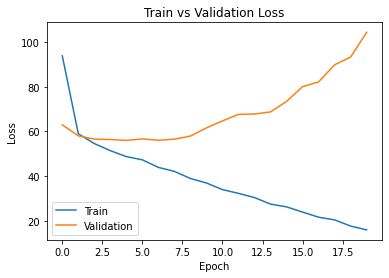

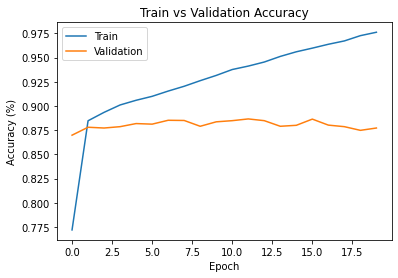

In [34]:
train(BATCH=200)

**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizer.

# Early Stopping

**Questions 16** [3 points]: 
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [15]:
# Your implementation of the model should go here
gru_rnn_early = objax.nn.Sequential([
    Embed(max_vocab, embedding_size),
    GRU(embedding_size, num_hidden_units_GRU),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),    
    objax.nn.Linear(num_hidden_units, 2)
])

In [16]:
## Your implementaiton of the optimizer should go here
opt_early = objax.optimizer.Adam(gru_rnn_early.vars())

You will also need the following functions.

In [17]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn_early(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv_early = objax.GradValues(loss_function, gru_rnn_early.vars())


@objax.Function.with_vars(gv_early.vars() + opt_early.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv_early(x, y)
    opt_early(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn_early(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn_early.vars())
predict = eval_op

In [18]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [22]:
# you code for the training loop should start here 
# you code for the training loop should start here 
def train(EPOCHS = 20, BATCH = 20, LEARNING_RATE = 9e-4):
  loss_increase = False
  loss_seq = 0

  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(messages_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, messages_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(messages_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
      train_acc_epoch.append(train_acc/messages_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

      # run validation
      val_indices = np.arange(len(messages_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, messages_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
          val_prediction = predict(messages_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
      val_acc_epoch.append(val_acc/messages_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

      if (avg_val_loss_epoch[len(avg_val_loss_epoch)-1] > avg_val_loss_epoch[len(avg_val_loss_epoch)-2]):
        if is_loss_increasing:
          loss_seq += 1
        else:
          is_loss_increasing = True
          loss_seq = 1
        
        if (loss_seq >= max_patience_window):
          print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 
                                                                                                                         100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))
          print("Unfortunately, the validation error has increased and we need to stop!")
          break

      else:
        is_loss_increasing = False
      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 
                                                                                                                     100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))
  
  # Print Test Accuracy
  print(f"Test Accuracy: {round(float(accuracy(test_data))*100,2)}%")

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  #Plot accuracy 
  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()




**Question 16**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

Epoch 0001  Training Loss 138.20 Validation Loss 137.39 Training Accuracy 54.88 Validation Accuracy 55.22
Epoch 0002  Training Loss 135.58 Validation Loss 132.50 Training Accuracy 59.09 Validation Accuracy 58.88
Epoch 0003  Training Loss 130.65 Validation Loss 124.52 Training Accuracy 62.60 Validation Accuracy 64.20
Epoch 0004  Training Loss 125.22 Validation Loss 121.62 Training Accuracy 65.64 Validation Accuracy 65.72
Epoch 0005  Training Loss 121.15 Validation Loss 114.95 Training Accuracy 68.65 Validation Accuracy 68.64
Epoch 0006  Training Loss 116.81 Validation Loss 112.26 Training Accuracy 70.23 Validation Accuracy 71.02
Epoch 0007  Training Loss 112.91 Validation Loss 114.63 Training Accuracy 72.15 Validation Accuracy 69.68
Epoch 0008  Training Loss 109.26 Validation Loss 103.87 Training Accuracy 73.60 Validation Accuracy 73.92
Epoch 0009  Training Loss 107.15 Validation Loss 116.05 Training Accuracy 74.64 Validation Accuracy 69.22
Epoch 0010  Training Loss 104.54 Validation Lo

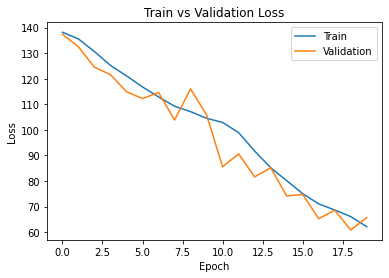

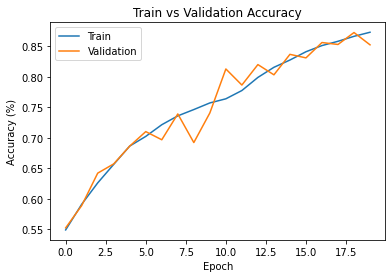

In [35]:
train(BATCH=200)

Epoch 0001  Training Loss 61.00 Validation Loss 60.32 Training Accuracy 87.80 Validation Accuracy 86.92
Epoch 0002  Training Loss 58.31 Validation Loss 56.99 Training Accuracy 88.64 Validation Accuracy 88.00
Epoch 0003  Training Loss 57.53 Validation Loss 54.87 Training Accuracy 88.73 Validation Accuracy 88.56
Epoch 0004  Training Loss 55.55 Validation Loss 54.18 Training Accuracy 89.34 Validation Accuracy 88.66
Epoch 0005  Training Loss 53.46 Validation Loss 62.72 Training Accuracy 89.73 Validation Accuracy 86.14
Epoch 0006  Training Loss 52.50 Validation Loss 53.93 Training Accuracy 90.07 Validation Accuracy 88.56
Epoch 0007  Training Loss 51.08 Validation Loss 53.05 Training Accuracy 90.37 Validation Accuracy 89.10
Epoch 0008  Training Loss 50.07 Validation Loss 66.13 Training Accuracy 90.60 Validation Accuracy 85.74
Epoch 0009  Training Loss 48.87 Validation Loss 51.66 Training Accuracy 90.92 Validation Accuracy 89.12
Epoch 0010  Training Loss 48.23 Validation Loss 51.80 Training A

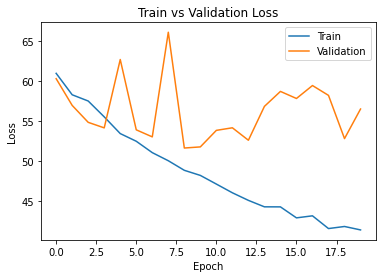

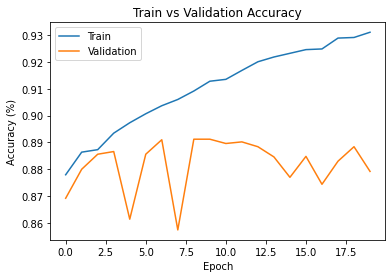

In [36]:
train(BATCH=200)

Epoch 0001  Training Loss 40.05 Validation Loss 53.15 Training Accuracy 93.47 Validation Accuracy 89.14
Epoch 0002  Training Loss 39.44 Validation Loss 53.53 Training Accuracy 93.58 Validation Accuracy 88.94
Epoch 0003  Training Loss 43.71 Validation Loss 59.81 Training Accuracy 92.75 Validation Accuracy 87.74
Epoch 0004  Training Loss 38.93 Validation Loss 53.76 Training Accuracy 93.72 Validation Accuracy 88.92
Epoch 0005  Training Loss 38.53 Validation Loss 54.26 Training Accuracy 93.92 Validation Accuracy 88.32
Epoch 0006  Training Loss 37.80 Validation Loss 57.06 Training Accuracy 94.04 Validation Accuracy 88.42
Epoch 0007  Training Loss 36.50 Validation Loss 55.35 Training Accuracy 94.38 Validation Accuracy 89.08
Epoch 0008  Training Loss 36.34 Validation Loss 59.56 Training Accuracy 94.36 Validation Accuracy 87.90
Epoch 0009  Training Loss 36.29 Validation Loss 55.47 Training Accuracy 94.48 Validation Accuracy 88.66
Epoch 0010  Training Loss 34.97 Validation Loss 58.12 Training A

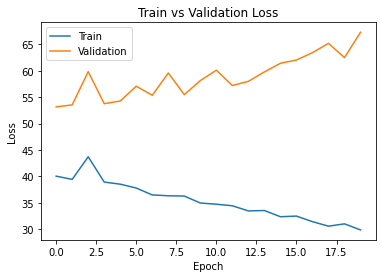

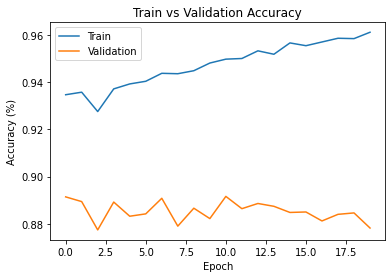

In [37]:
train(BATCH=200)